# Exploratory Time Series Analysis

## Goal

This purpose of this notebook is to compute the trend and seasonality based on the training data. Then we add two columns: "Trips_no_trend" and "Trips_no_season" to both train and test csv. 
1. "Trips_no_trend" = "Bike_trips" - "Trend"
2. "Trips_no_season" = "Bike_trips" - "Seasonality"

Remark: The trend and seasonality regression are computed based purely on training data to avoid data leakage.

## Import Data

In [1]:
# import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date, datetime, timedelta

In [2]:
sns.set_style('whitegrid')

In [3]:
bike_train = pd.read_csv('../bikeshare_train_data.csv')
bike_test = pd.read_csv('../bikeshare_test_data.csv')

In [4]:
bike_train.head()

,Date,day_length,min_temp,max_temp,mean_temp,temp_diff,hdd,cdd,rain,snow,total_precip,snow_on_ground,max_gust,mean_dep_temp,mean_ret_temp,mean_ride_temp,total_dist,total_duration,ebike_trips,num_trips
0,2017-01-01,497.133333,-2.3,2.2,-0.1,4.5,18.1,0.0,0.0,0.0,0.0,3.0,10.0,3.555556,4.296296,3.925926,338025.0,232693.0,0.0,162
1,2017-01-02,498.133333,-6.0,1.4,-2.3,7.4,20.3,0.0,0.0,0.0,0.0,2.0,0.0,2.718519,3.688889,3.203704,660054.0,382729.0,0.0,270
2,2017-01-03,499.133333,-7.8,0.4,-3.7,8.2,21.7,0.0,0.0,0.0,0.0,1.0,0.0,0.807292,1.791667,1.299479,635395.0,376013.0,0.0,384
3,2017-01-04,501.133333,-8.4,2.2,-3.1,10.6,21.1,0.0,0.0,0.0,0.0,1.0,1.0,2.767391,3.643478,3.205435,766082.0,376721.0,0.0,460
4,2017-01-05,502.133333,-6.6,0.7,-3.0,7.3,21.0,0.0,0.0,0.0,0.0,1.0,0.0,2.601145,3.524809,3.062977,888222.0,524933.0,0.0,524


In [5]:
bike_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2311 entries, 0 to 2310
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Date            2311 non-null   object 
 1   day_length      2311 non-null   float64
 2   min_temp        2311 non-null   float64
 3   max_temp        2311 non-null   float64
 4   mean_temp       2311 non-null   float64
 5   temp_diff       2311 non-null   float64
 6   hdd             2311 non-null   float64
 7   cdd             2311 non-null   float64
 8   rain            2311 non-null   float64
 9   snow            2311 non-null   float64
 10  total_precip    2311 non-null   float64
 11  snow_on_ground  2311 non-null   float64
 12  max_gust        2311 non-null   float64
 13  mean_dep_temp   2311 non-null   float64
 14  mean_ret_temp   2311 non-null   float64
 15  mean_ride_temp  2311 non-null   float64
 16  total_dist      2311 non-null   float64
 17  total_duration  2311 non-null   f

In [6]:
#split the date into the following columns: Year-Month, Year, Month, Day
def get_year(date_str):
    return(date_str.split('-')[0])
def get_month(date_str):
    return(date_str.split('-')[1])
def get_day(date_str):
    return(date_str.split('-')[2])
def get_year_month(date_str):
    return ('-'.join((date_str.split('-')[0],date_str.split('-')[1])))

In [8]:
bike_train['Year-Month'] = bike_train['Date'].apply(get_year_month)
bike_train['Year'] = bike_train['Date'].apply(get_year)
bike_train['Month'] = bike_train['Date'].apply(get_month)
bike_train['Day'] = bike_train['Date'].apply(get_day)

bike_test['Year-Month'] = bike_test['Date'].apply(get_year_month)
bike_test['Year'] = bike_test['Date'].apply(get_year)
bike_test['Month'] = bike_test['Date'].apply(get_month)
bike_test['Day'] = bike_test['Date'].apply(get_day)

## Trend in Years

We first visualize the time series in the scale of years.

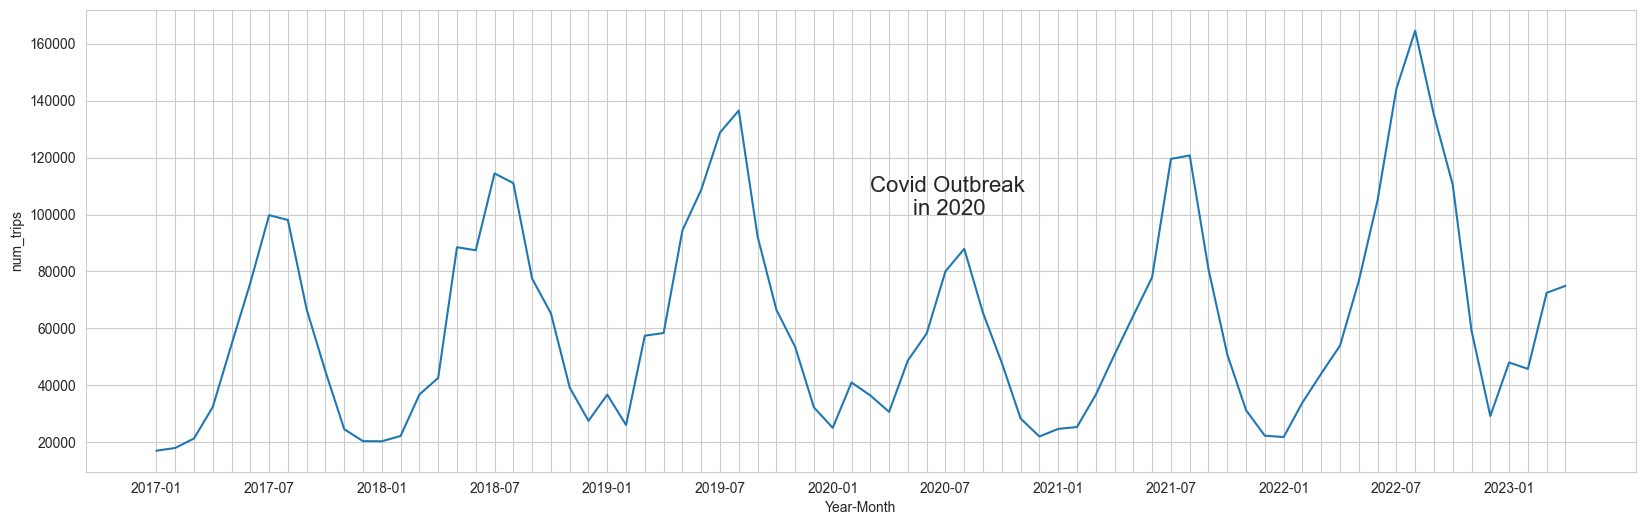

In [11]:
plt.figure(figsize=(20,6))
ax = sns.lineplot(data=bike_train.groupby('Year-Month')['num_trips'].sum().reset_index(),x='Year-Month',y='num_trips')
for ind, label in enumerate(ax.get_xticklabels()):
    if ind % 6 == 0:  # every 6th label is kept
        label.set_visible(True)
    else:
        label.set_visible(False)
plt.text(s = 'Covid Outbreak \n       in 2020', x = '2020-03', y = 100000, fontsize=16)

plt.show()

Despite the sudden decrease in year 2020, which is very likely related to the initial Covid 19 outbreak, the bike trips number show a trend of stready growth in years. 

We will plot the linear regression from the start of year 2017 to the end of year 2019, and from the start of year 2021 to the end of year 2023. 

In [17]:
bike_train_1 = bike_train.loc[bike_train.Year < '2020']
bike_train_2 = bike_train.loc[bike_train.Year > '2020'].loc[bike_train.Year < '2023']

Remark: If you want to include year 2020, simply edit bike_train_2.loc conditions

In [18]:
def str_to_date(s):
    return (datetime.strptime(s,'%Y-%m'))

In [19]:
cong_1 = bike_train_1.groupby('Year-Month')['num_trips'].sum().reset_index()
cong_1['Year-Month'] = pd.to_datetime(cong_1['Year-Month']).apply(lambda date: date.toordinal())
cong_2 = bike_train_2.groupby('Year-Month')['num_trips'].sum().reset_index()
cong_2['Year-Month'] = pd.to_datetime(cong_2['Year-Month']).apply(lambda date: date.toordinal())

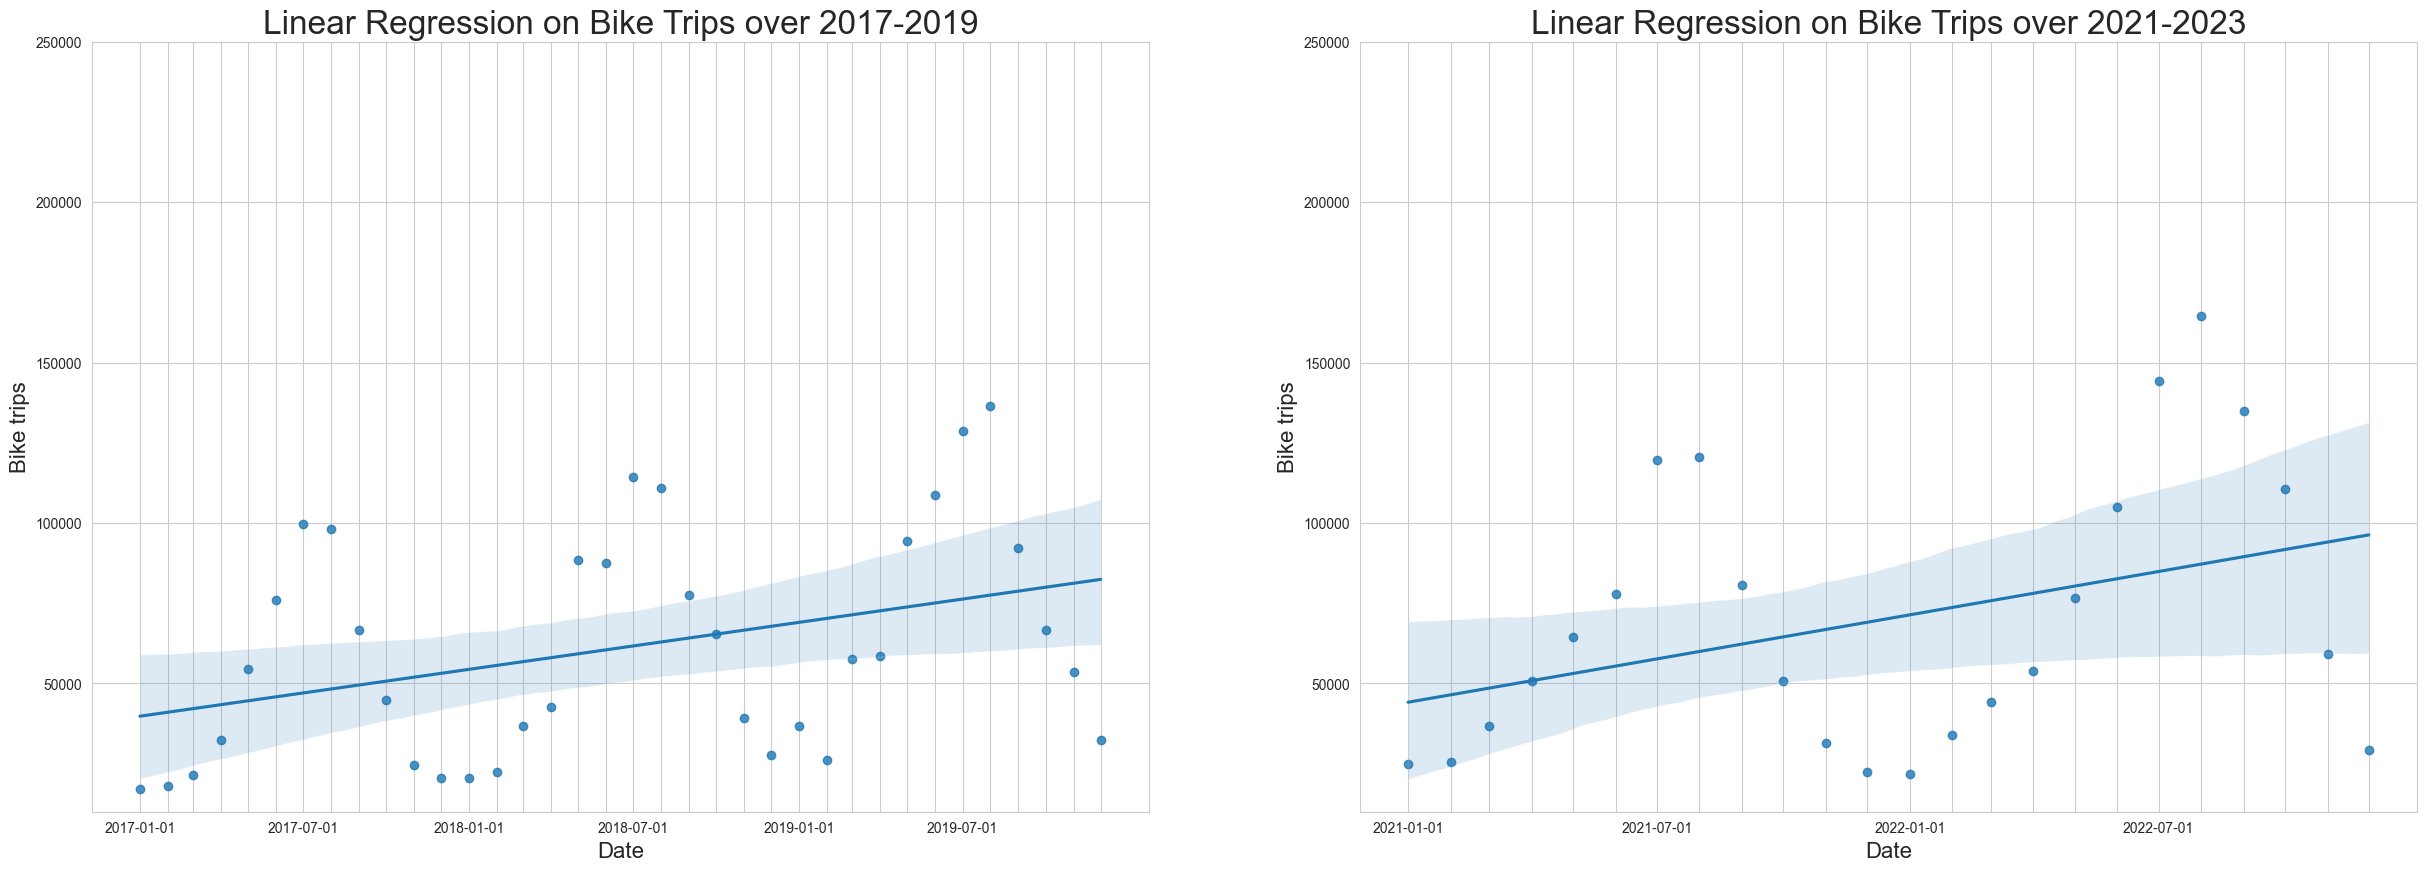

In [20]:
# set figure size
fig, ax = plt.subplots(nrows=1, ncols=2)
fig.set_figheight(10)
fig.set_figwidth(30)

# plot the 2017-2019 regplot
sns.regplot(data = cong_1, x = 'Year-Month', y='num_trips', ax=ax[0])

# set ax[0] x ticks
ax[0].set_xticks(cong_1['Year-Month'])
new_labels = [date.fromordinal(int(item)) for item in ax[0].get_xticks()]
ax[0].set_xticklabels(new_labels)
for ind, label in enumerate(ax[0].get_xticklabels()):
    if ind % 6 == 0:  # every 6th label is kept
        label.set_visible(True)
    else:
        label.set_visible(False)
        
# set ax[0] y ticks
ax[0].set_ylim(10000,250000)
ax[0].set_xlabel('Date',fontsize=16)
ax[0].set_ylabel('Bike trips',fontsize=16)
ax[0].set_title('Linear Regression on Bike Trips over 2017-2019', fontsize=24)


sns.regplot(data = cong_2, x = 'Year-Month', y='num_trips',ax=ax[1])
ax[1].set_xticks(cong_2['Year-Month'])
new_labels = [date.fromordinal(int(item)) for item in ax[1].get_xticks()]
ax[1].set_xticklabels(new_labels)
for ind, label in enumerate(ax[1].get_xticklabels()):
    if ind % 6 == 0:  # every 6th label is kept
        label.set_visible(True)
    else:
        label.set_visible(False)
ax[1].set_ylim(10000,250000)
ax[1].set_xlabel('Date',fontsize=16)
ax[1].set_ylabel('Bike trips',fontsize=16)

ax[1].set_title('Linear Regression on Bike Trips over 2021-2023', fontsize=24)

plt.show()

The linear reg plot shows the growing trend both before and after year 2020.

We will then plot the residue of the linear regression.

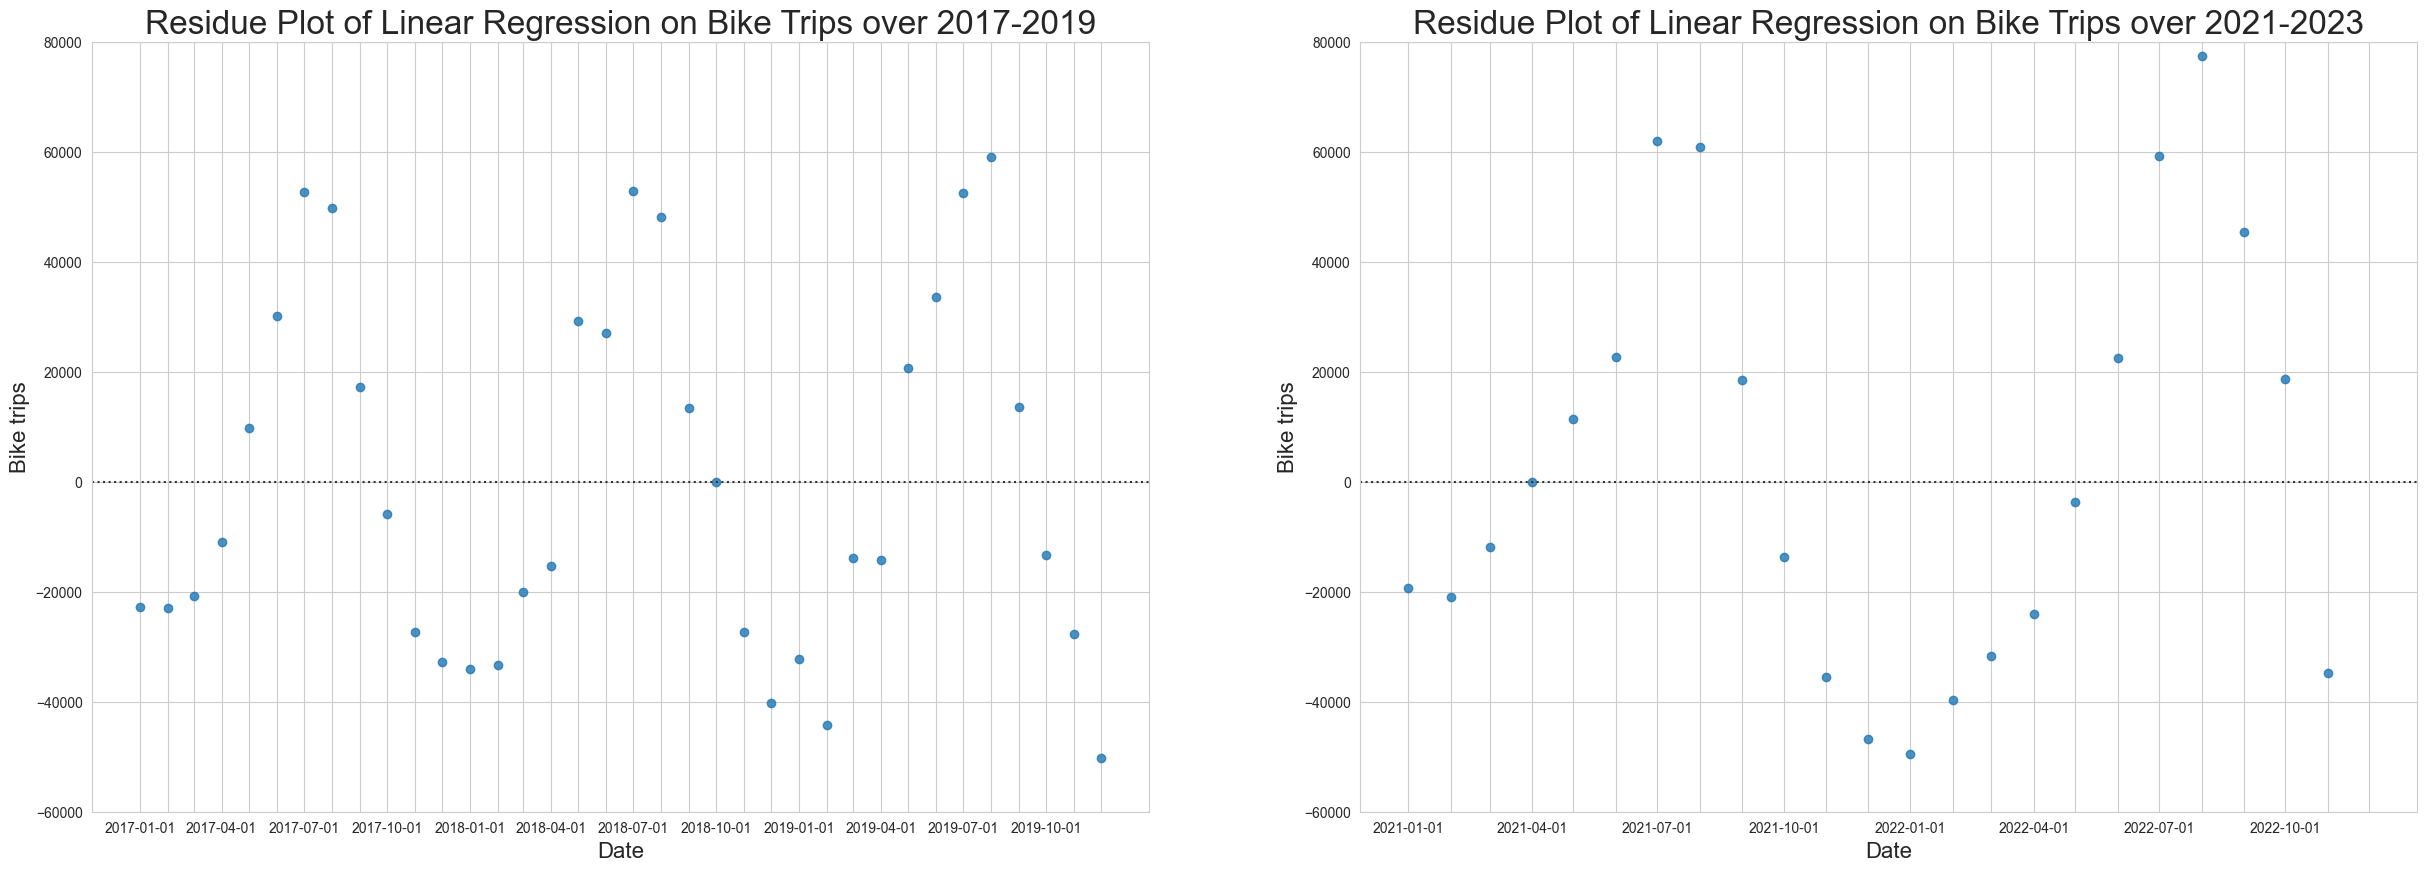

In [21]:
# set figure size
fig, ax = plt.subplots(nrows=1, ncols=2)
fig.set_figheight(10)
fig.set_figwidth(30)

# plot the 2017-2019 regplot
sns.residplot(data = cong_1, x = 'Year-Month', y='num_trips', ax=ax[0])

# set ax[0] x ticks
ax[0].set_xticks(cong_1['Year-Month'])
new_labels = [date.fromordinal(int(item)) for item in ax[0].get_xticks()]
ax[0].set_xticklabels(new_labels)
for ind, label in enumerate(ax[0].get_xticklabels()):
    if ind % 3 == 0:  # every 3th label is kept
        label.set_visible(True)
    else:
        label.set_visible(False)
        
# set ax[0] y ticks
ax[0].set_ylim(-60000,80000)
ax[0].set_xlabel('Date',fontsize=16)
ax[0].set_ylabel('Bike trips',fontsize=16)
ax[0].set_title('Residue Plot of Linear Regression on Bike Trips over 2017-2019', fontsize=24)

# Do the same thing for year 2021-2023
sns.residplot(data = cong_2, x = 'Year-Month', y='num_trips',ax=ax[1])
ax[1].set_xticks(cong_2['Year-Month'])
new_labels = [date.fromordinal(int(item)) for item in ax[1].get_xticks()]
ax[1].set_xticklabels(new_labels)
for ind, label in enumerate(ax[1].get_xticklabels()):
    if ind % 3 == 0:  # every 3th label is kept
        label.set_visible(True)
    else:
        label.set_visible(False)
ax[1].set_ylim(-60000,80000)
ax[1].set_xlabel('Date',fontsize=16)
ax[1].set_ylabel('Bike trips',fontsize=16)

ax[1].set_title('Residue Plot of Linear Regression on Bike Trips over 2021-2023', fontsize=24)
plt.show()

The residue looks free of trend, except for the magnitude of the periodic fluctuation. In fact, we may apply a regression model with sin(date) and cos(date) as independent variable to further explore the residue. We will do that in the next section: Seasonality.

One remaining thing in this section is to consider the possible causes for the yearly growing trend. This could be of significance in predicting whether this trend is going to continue. A lot of factors could contribute to the yearly growth. For example, increasing investment by Mobi into the bike infrastructure, change in city's demography, change in overall temperature are all possible factors. 

However, these factors might contribute differently to the future trend in yearly growth. For example, if this growth is mainly caused by the increasing investment by Mobi into the city bike infrastructure, the growing trend may reach a threshold when the bike numbers meet the requirement. But if other factors like population and climate are at play, then the trend may be more long lasting.

To check the possible influence of climate change, we will plot the monthly average temperature and precipitation together with the bike trips data.

In [23]:
climate = bike_train[['Year-Month','mean_temp','total_precip']]

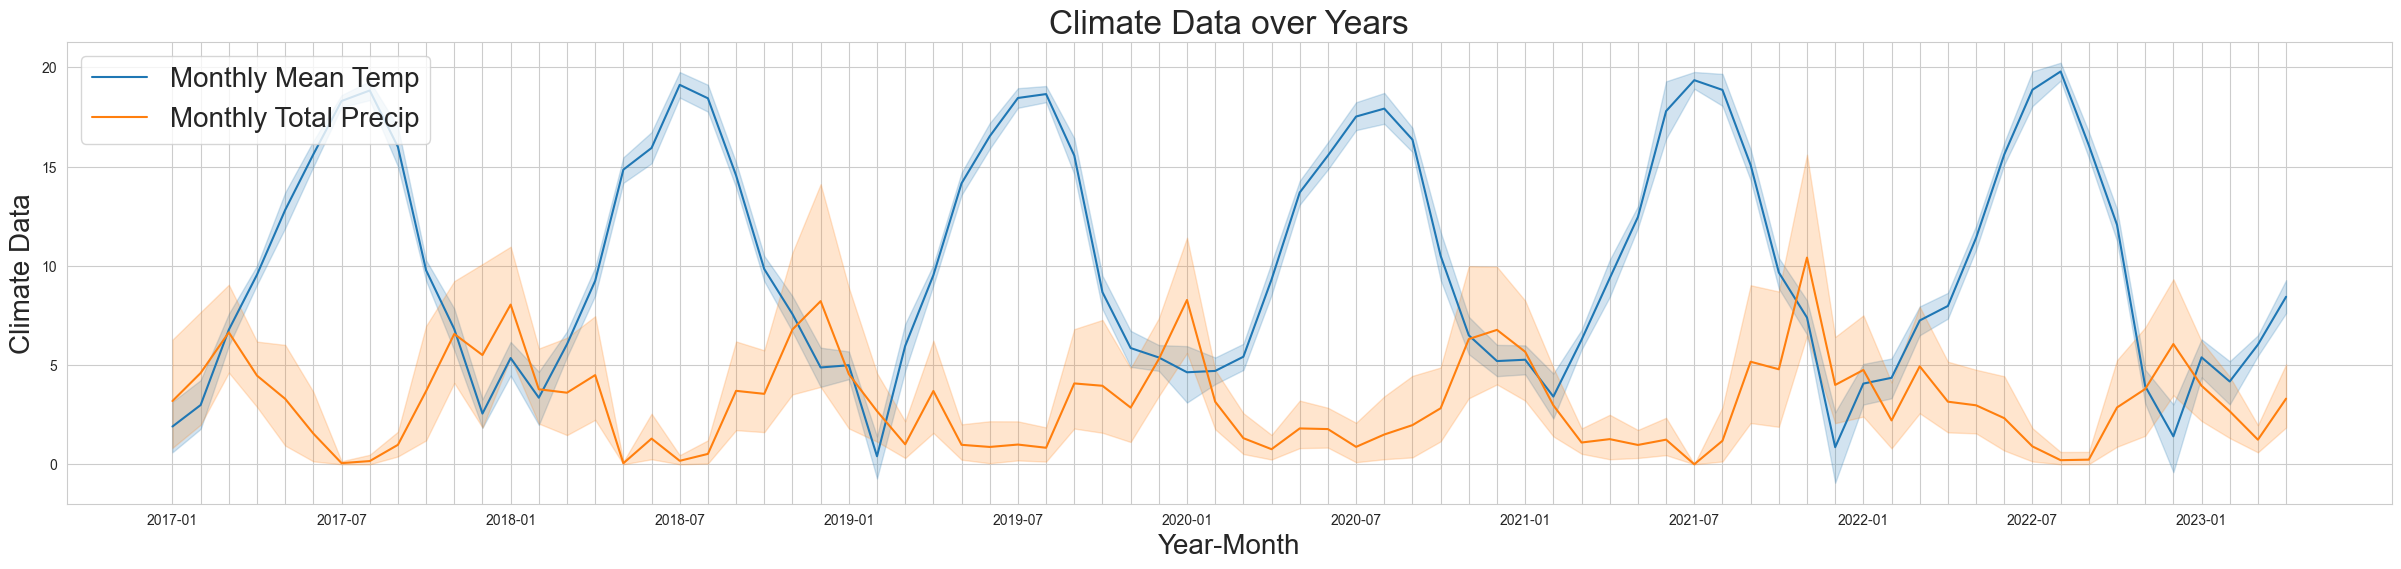

In [26]:
fig, ax = plt.subplots(1,1)
fig.set_figheight(6)
fig.set_figwidth(30)

sns.lineplot(data=climate, x='Year-Month', y='mean_temp', ax=ax, label='Monthly Mean Temp')
sns.lineplot(data=climate, x='Year-Month', y='total_precip', ax=ax, label='Monthly Total Precip')
for ind, label in enumerate(ax.get_xticklabels()):
    if ind % 6 == 0:  # every 6th label is kept
        label.set_visible(True)
    else:
        label.set_visible(False)
ax.set_xlabel('Year-Month', fontsize=20)
ax.set_ylabel('Climate Data', fontsize=20)
plt.title('Climate Data over Years',fontsize=24)
plt.legend(loc=2,fontsize=20)
plt.show()


Climate data does not show trend in years. The bike usage trend in years is likely caused by other factors.

A much more likely cause of yearly growth is improvement in Mobi's own infrastructure, e.g. increased bike numbers, expanded service areas, more docks, etc. 

However, these data are difficult to find. One thing that can be gleaned from our existing data is the total number of bike stations. We can assume the total stations number of a month to be the count of all unique Departure station name of that month. 

In [27]:
def get_weather_month(s):
    return(int(s.split('/')[0]))

In [31]:
station_count = []

In [32]:
# import 2017 data
df = pd.read_csv('../preprocessing/bike data/raw data/All of 2017.csv')
df['Month'] = df['Departure'].apply(get_weather_month)
station_count.extend(df.groupby('Month')['Departure station'].nunique())
del(df)

In [33]:
for year in range(2018,2024):
    for month in ['January','February','March','April','May','June','July','August','September','October','November','December']:
        filepath = '../preprocessing/bike data/raw data/' + month + ' ' + str(year) + '.csv'
        df = pd.read_csv(filepath)
        station_count.append(df['Departure station'].nunique())
        del(df)

/var/folders/z_/vfnvng3n3hg_y07yr6f3l64w0000gn/T/ipykernel_75796/1655466370.py:4: DtypeWarning: Columns (0,1,2,3,4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(filepath)
/var/folders/z_/vfnvng3n3hg_y07yr6f3l64w0000gn/T/ipykernel_75796/1655466370.py:4: DtypeWarning: Columns (0,1,2,3,4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(filepath)
/var/folders/z_/vfnvng3n3hg_y07yr6f3l64w0000gn/T/ipykernel_75796/1655466370.py:4: DtypeWarning: Columns (0,1,2,3,4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(filepath)
/var/folders/z_/vfnvng3n3hg_y07yr6f3l64w0000gn/T/ipykernel_75796/1655466370.py:4: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(filepath)
/var/folders/z_/vfnvng3n3hg_y07yr6f3l64w0000gn/T/ipykernel_75796/1655466370.py:4: DtypeWarning: Columns (2) have mixed types. 

In [36]:
Year_Month = [str(year) + '-' + str(month) for year in range(2017,2024) for month in range(1,13)]

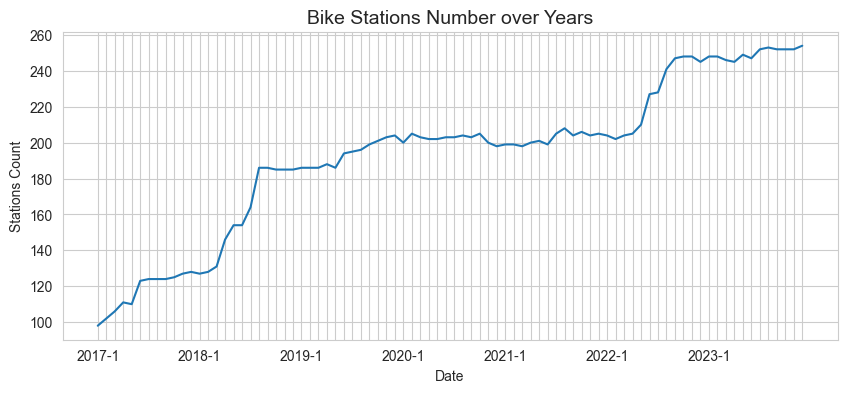

In [38]:
fig, ax = plt.subplots(1,1)
fig.set_figheight(4)
fig.set_figwidth(10)

sns.lineplot(x=Year_Month, y=station_count[:len(Year_Month)], ax=ax)
for ind, label in enumerate(ax.get_xticklabels()):
    if ind % 12 == 0:  # every 12th label is kept
        label.set_visible(True)
    else:
        label.set_visible(False)
ax.set_xlabel('Date',fontsize=10)
ax.set_ylabel('Stations Count',fontsize=10)
plt.title('Bike Stations Number over Years',fontsize=14)
plt.show()

Based on the plot, the increasing number of bike stations and expanded service region likely contributed to the yearly bike usage growth. 

Conclusion : 
1. Since our kpi/goal is to predict the bike usage in days or at most weeks, yearly trend seems irrelevant at first to our prediction. However, its existence implies that the weather conditions (and other relevant variables) are not the only factors that contributes to bike usage.
2. For example, suppose we want to do a linear regression, whose independent variables are 'Temp', 'Precip' and 'Daylight', and whose datasets containing data from 2017 to 2024. We will have to preprocess the data by somehow seperating the contribution of the yearly growing trend from the total bike usage. Otherwise, our dataset will be biased over years.
3. Whether this growing trend should continue from 2024 is unclear at this moment. Because (at least a part of) the trend is caused by increasing number of bike stations, expanded service region and etc, such growth could reach a threshold at some time, if the bike service meets the demand of the city population.

## Remove seasonality by Trigno Regression

In this section, we do linear regression on training set. Our goal is to find the coefficient for the linear approximation for trend, and the coefficient of the trigonometric functions for seasonality.

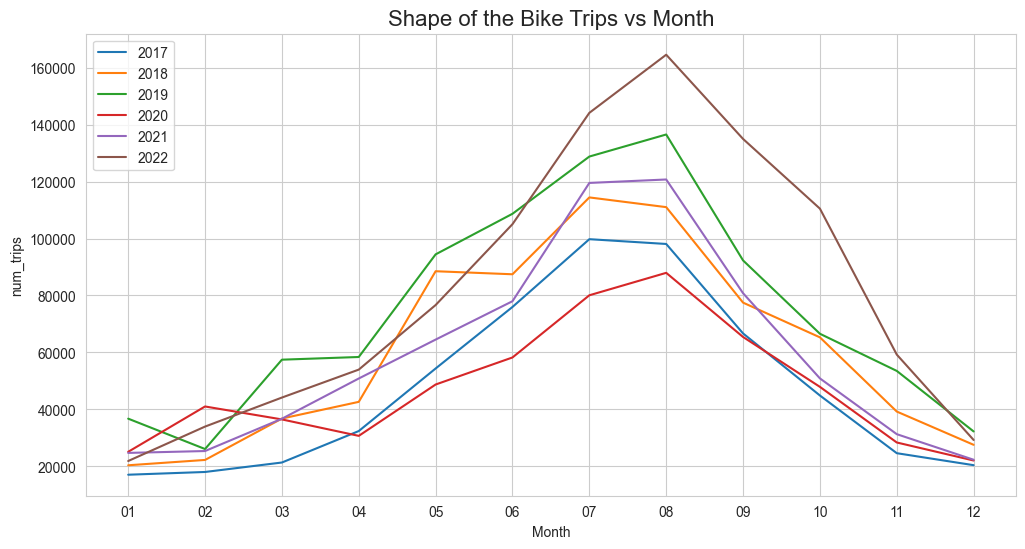

In [41]:
years = ['2017','2018','2019','2020','2021','2022']
months = ['01','02','03','04','05','06','07','08','09','10','11','12']
fig = plt.figure(figsize = (12,6))
for year in years:
    y_bike = bike_train.loc[bike_train['Year'] == year].groupby('Month')['num_trips'].sum()
    sns.lineplot(data=y_bike,label=year)
plt.legend(loc=2)
plt.title('Shape of the Bike Trips vs Month',fontsize = 16)
plt.show()

The seasonality in month is very likely cause by the difference of weather, teperature, precipitation, etc among months. This notebook will not delve into detailed model involving these factors. Instead, we will just do a preliminary exploration of the monthly seasonality. In particular, we will fit a mathematical model on residue

In [42]:
from sklearn.linear_model import LinearRegression

In [46]:
reg_1 = LinearRegression()
reg_1.fit(cong_1[['Year-Month']],cong_1['num_trips'])

reg_2 = LinearRegression()
reg_2.fit(cong_2[['Year-Month']],cong_2['num_trips'])

LinearRegression()

Here we get the coefficients of the two linear regression over 2017-2019 and 2021-2023.

In [54]:
print(f'Over 2017-2019 period, the slope of the trend is {reg_1.coef_} and the intercept is {reg_1.intercept_}')
print(f'Over 2021-2023 period, the slope of the trend is {reg_2.coef_} and the intercept is {reg_2.intercept_}')

Over 2017-2019 period, the slope of the trend is [40.07457142] and the intercept is -29468337.143771846
Over 2021-2023 period, the slope of the trend is [74.61492352] and the intercept is -55006091.18569324


In [47]:
cong_1['Residue'] = cong_1['num_trips'] - reg_1.predict(cong_1[['Year-Month']])
cong_2['Residue'] = cong_2['num_trips'] - reg_2.predict(cong_2[['Year-Month']])

In [48]:
cong_1['Converted-Date'] = cong_1['Year-Month']/365*2*np.pi
cong_2['Converted-Date'] = cong_2['Year-Month']/365*2*np.pi

In [50]:
cong_1['Cos'] = np.cos(cong_1['Converted-Date'].values)
cong_1['Sin'] = np.sin(cong_1['Converted-Date'].values)
cong_2['Cos'] = np.cos(cong_2['Converted-Date'].values)
cong_2['Sin'] = np.sin(cong_2['Converted-Date'].values)

In [51]:
reg_3 = LinearRegression()
reg_3.fit(cong_1[['Cos','Sin']],cong_1['Residue'])

reg_4 = LinearRegression()
reg_4.fit(cong_2[['Cos','Sin']],cong_2['Residue'])


LinearRegression()

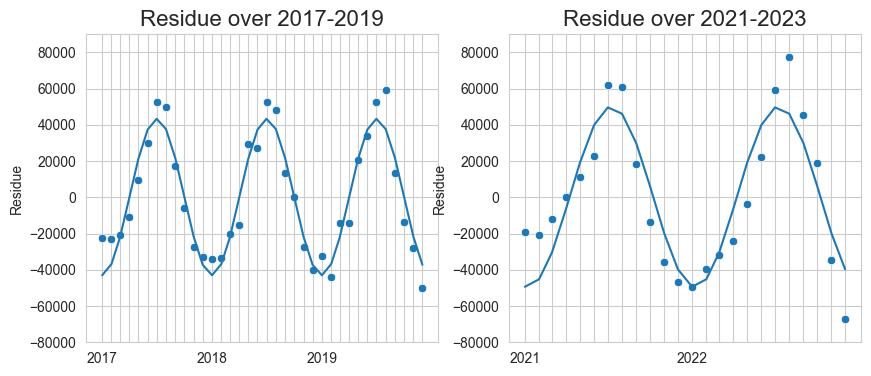

In [53]:
fig, ax = plt.subplots(nrows = 1, ncols = 2)
fig.set_figheight(4)
fig.set_figwidth(10)
sns.lineplot(x = cong_1['Year-Month'].values, y = reg_3.predict(cong_1[['Cos','Sin']]), ax = ax[0])
sns.scatterplot(x = cong_1['Year-Month'].values, y = cong_1['Residue'], ax = ax[0])
ax[0].set_xticks(cong_1['Year-Month'])
new_labels = [date.fromordinal(int(item)).year for item in ax[0].get_xticks()]
ax[0].set_xticklabels(new_labels)
for ind, label in enumerate(ax[0].get_xticklabels()):
    if ind % 12 == 0:  # every 12th label is kept
        label.set_visible(True)
    else:
        label.set_visible(False)
ax[0].set_title('Residue over 2017-2019',fontsize=16)
ax[0].set_ylim(-80000,90000)

sns.lineplot(x = cong_2['Year-Month'].values, y = reg_4.predict(cong_2[['Cos','Sin']]), ax = ax[1])
sns.scatterplot(x = cong_2['Year-Month'].values, y = cong_2['Residue'], ax = ax[1])
ax[1].set_xticks(cong_2['Year-Month'])
new_labels = [date.fromordinal(int(item)).year for item in ax[1].get_xticks()]
ax[1].set_xticklabels(new_labels)
for ind, label in enumerate(ax[1].get_xticklabels()):
    if ind % 12 == 0:  # every 12th label is kept
        label.set_visible(True)
    else:
        label.set_visible(False)
ax[1].set_title('Residue over 2021-2023',fontsize=16)
ax[1].set_ylim(-80000,90000)


plt.show()

Remark : There seems to be a linear increase in the ampitude of waves over years as well, which we did not implement.

Conclusion:
1. Regression plots of the residue using sin and cos functions seem fit.
2. This periodic behavior in months is clearly caused by the weather, daylight, etc. We should consider detailed models, e.g. regression, in a seperate notebook.
3. There is also a trend in the amptitude of the waves over the years, while the climate data shows no trend. This might also be something that we should incorporate when modelling.

## Remove Seasonality by Yearly Difference

In this section, we remove seasonality first by taking difference in 12 months spans. That will leave the yearly trend alone.

In [91]:
monthly_mean = bike_train.groupby('Year-Month')['num_trips'].mean()

In [92]:
monthly_mean_diff = monthly_mean.iloc[12:].values - monthly_mean.iloc[:-12].values

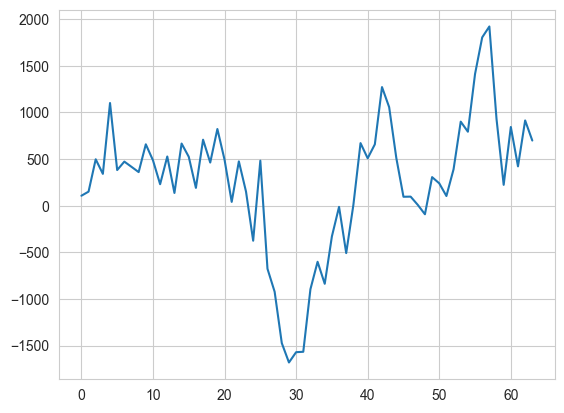

In [93]:
sns.lineplot(x=np.arange(len(monthly_mean_diff)),y=monthly_mean_diff)
plt.show()

## (No) Seasonality in Weekday

This section is mostly irrelevant. But I keep it there just for reference. In this section, we attempt to find any relations between bike usage and weekday(Mon, Tue, Wed, etc). The result shows little information, which is to be expected. At this time scale(daily), the bike usage is more likely to be influenced by the actual weather condition than by which weekday it is.

In [30]:
def get_weekday(d_string):
    return(datetime.strptime(d_string, '%Y-%m-%d').weekday())

In [31]:
# create a column showing which weekday it is
bike['Weekday'] = bike['Date'].apply(get_weekday)

In [32]:
#create another column in the form of 'w%d-%d'. For example, 'w1-0' means Sunday of week 1 of that year. 
bike['Week & Day'] = np.nan
bike['Week'] = np.nan

In [33]:
y_bike = bike.loc[bike.Year=='2017']
i = y_bike.index.min()
while y_bike.iloc[i]['Weekday'] != 0:
    i+=1
for index in range(i,y_bike.index.max()+1):
    week_no = (index-i)//7 + 1
    y_bike.loc[index, 'Week'] = week_no
    y_bike.loc[index, 'Week & Day'] = 'w' + str(week_no) + '-' + str(y_bike.iloc[index]['Weekday'])

/var/folders/z_/vfnvng3n3hg_y07yr6f3l64w0000gn/T/ipykernel_24741/3625831382.py:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'w1-0' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  y_bike.loc[index, 'Week & Day'] = 'w' + str(week_no) + '-' + str(y_bike.iloc[index]['Weekday'])


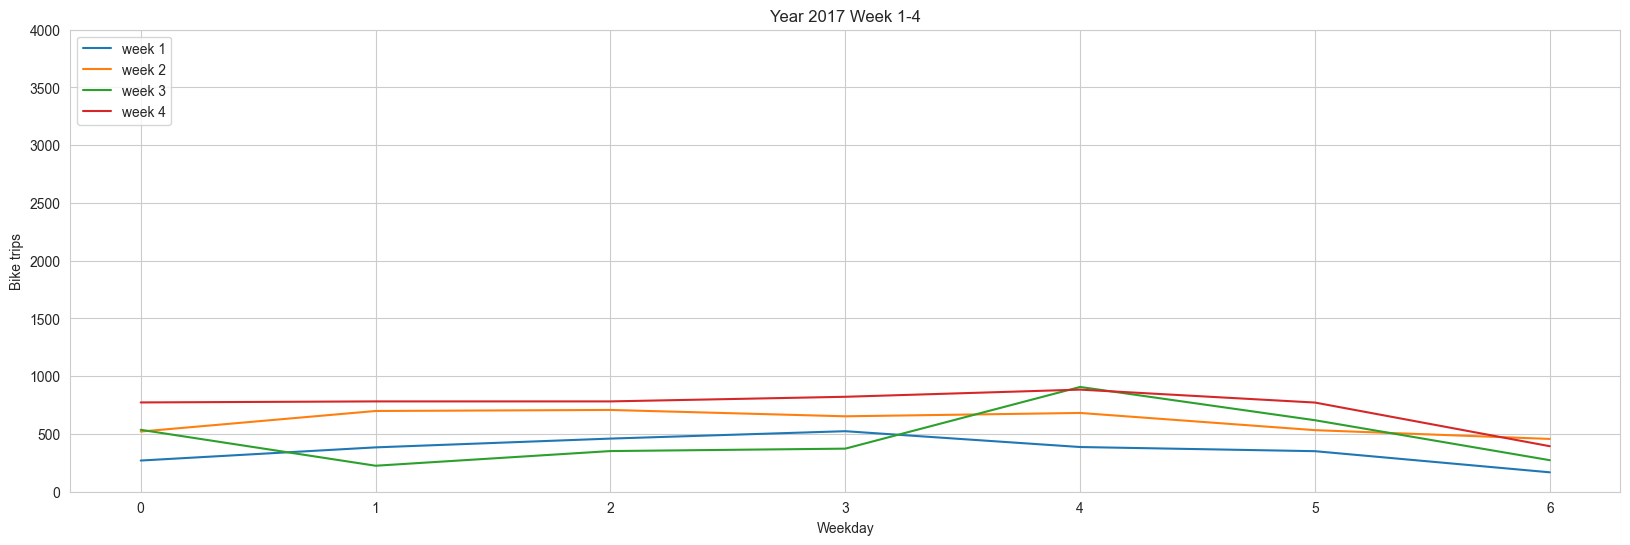

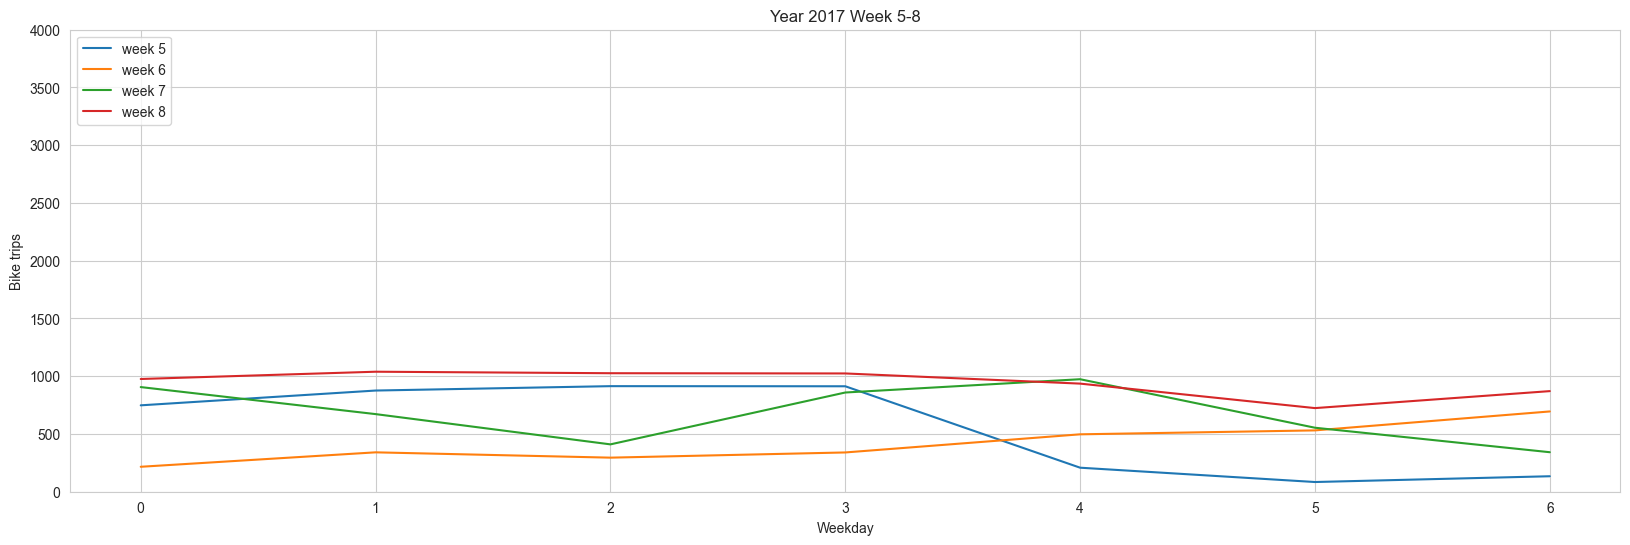

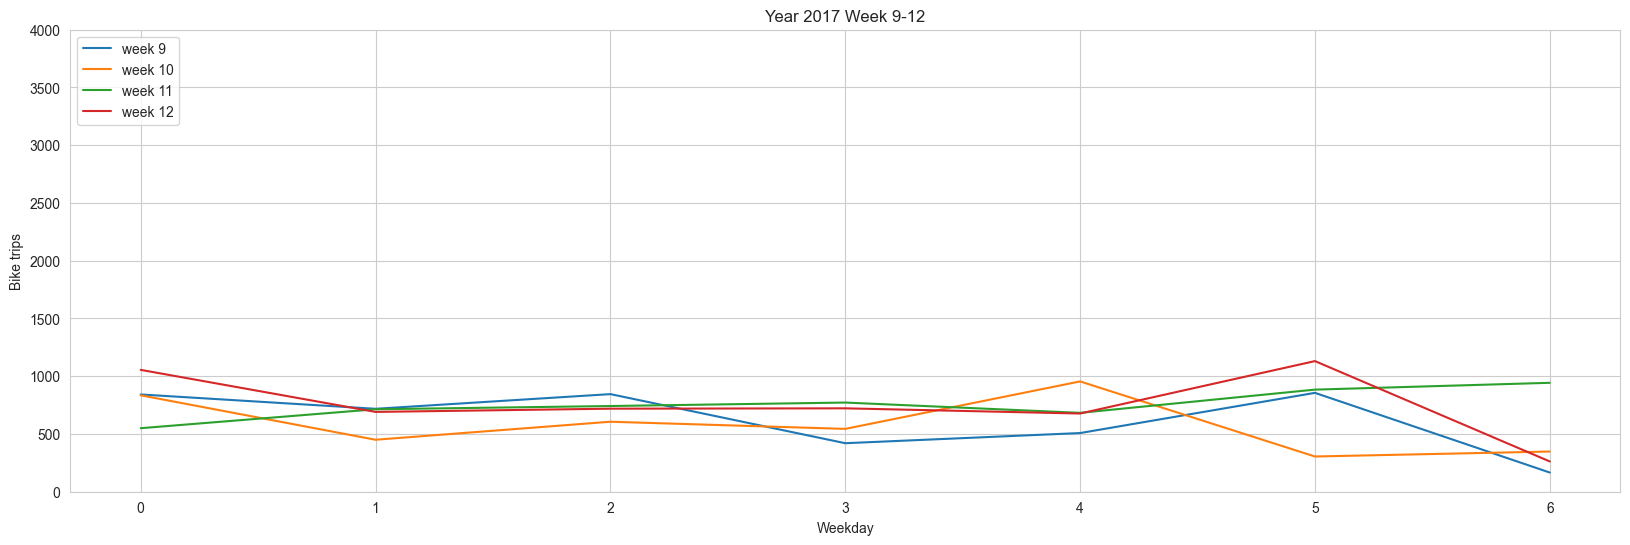

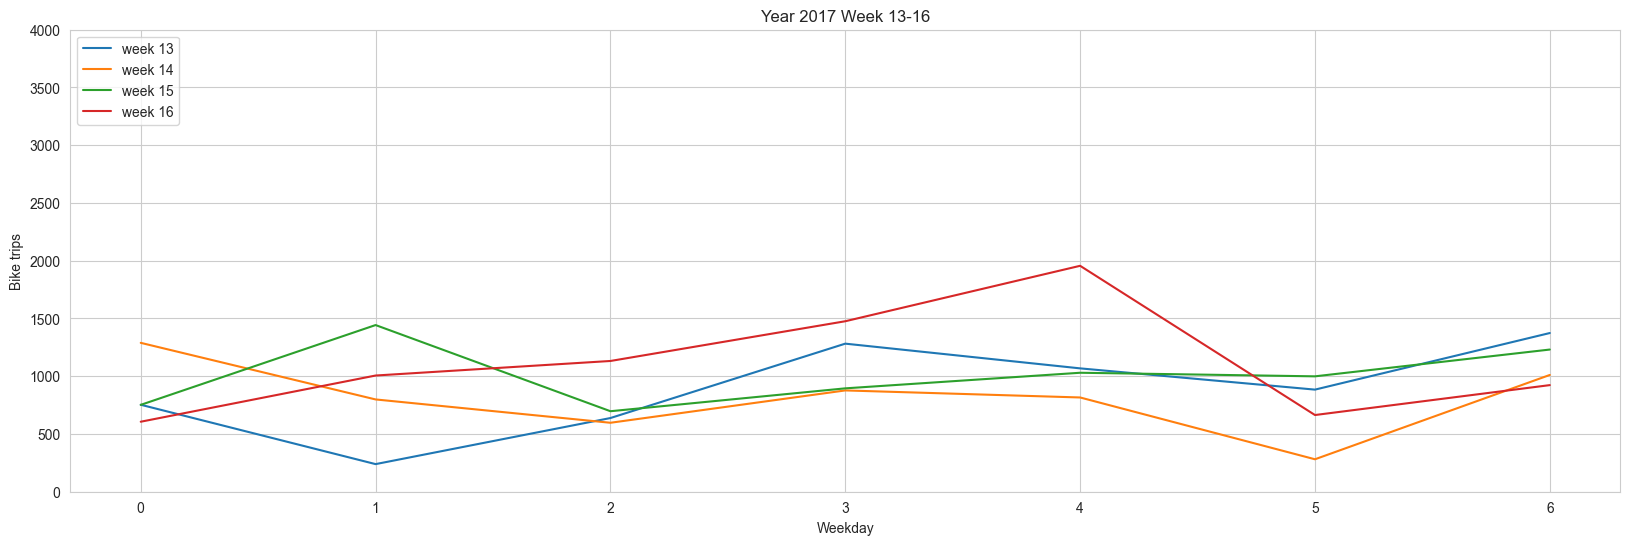

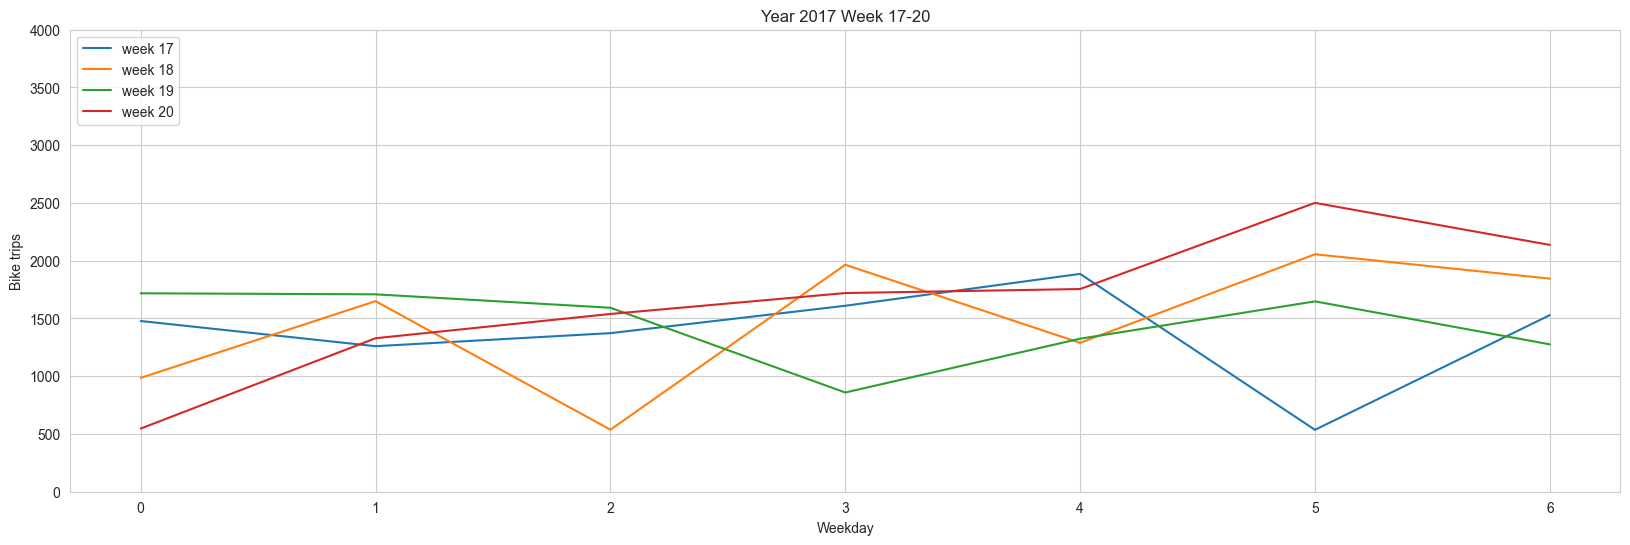

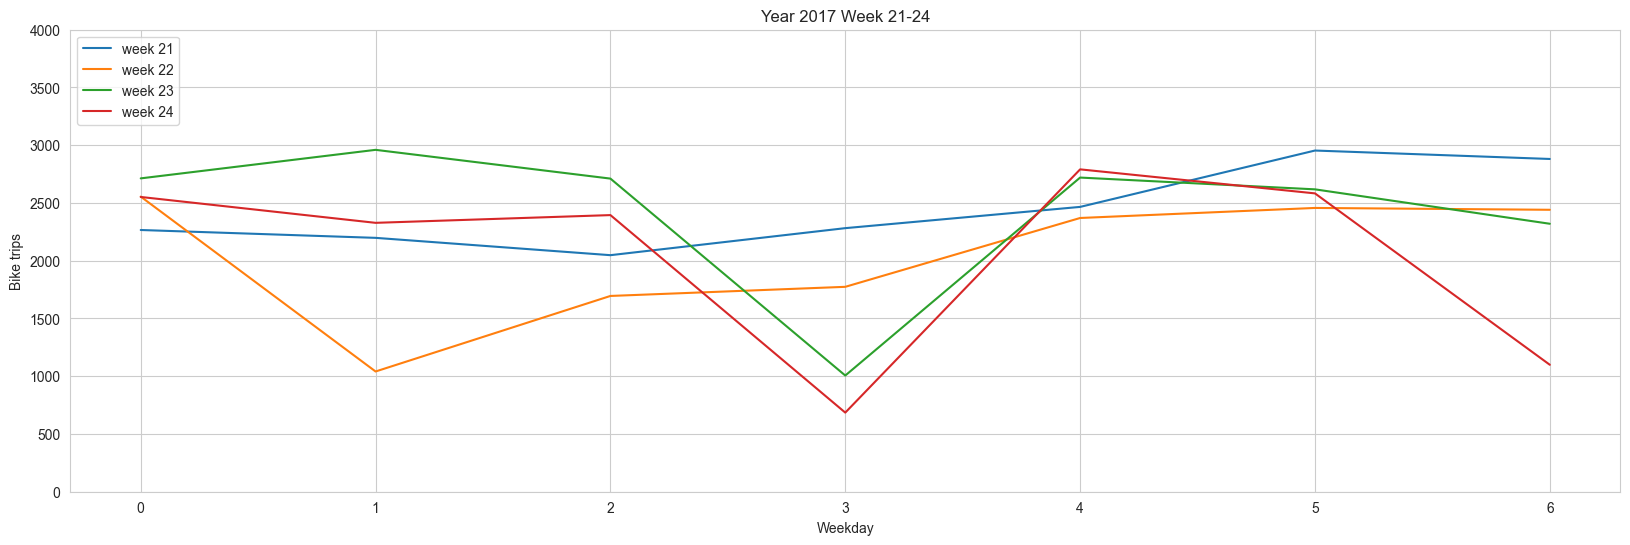

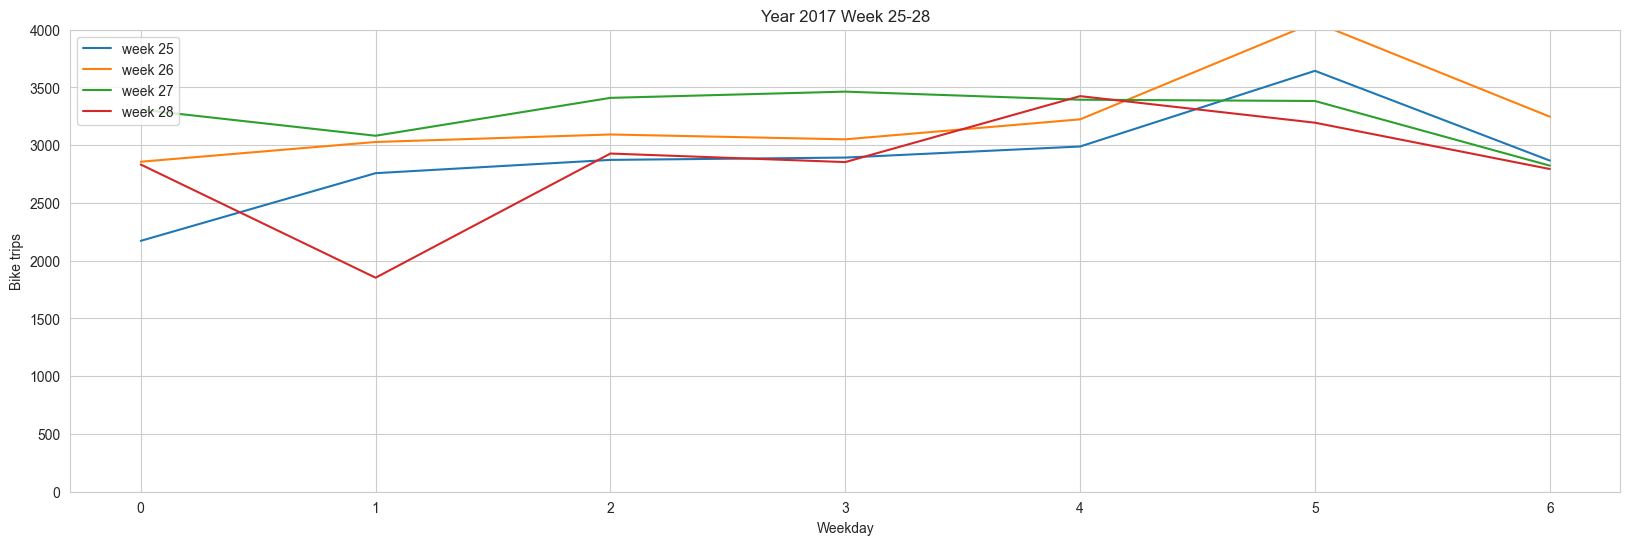

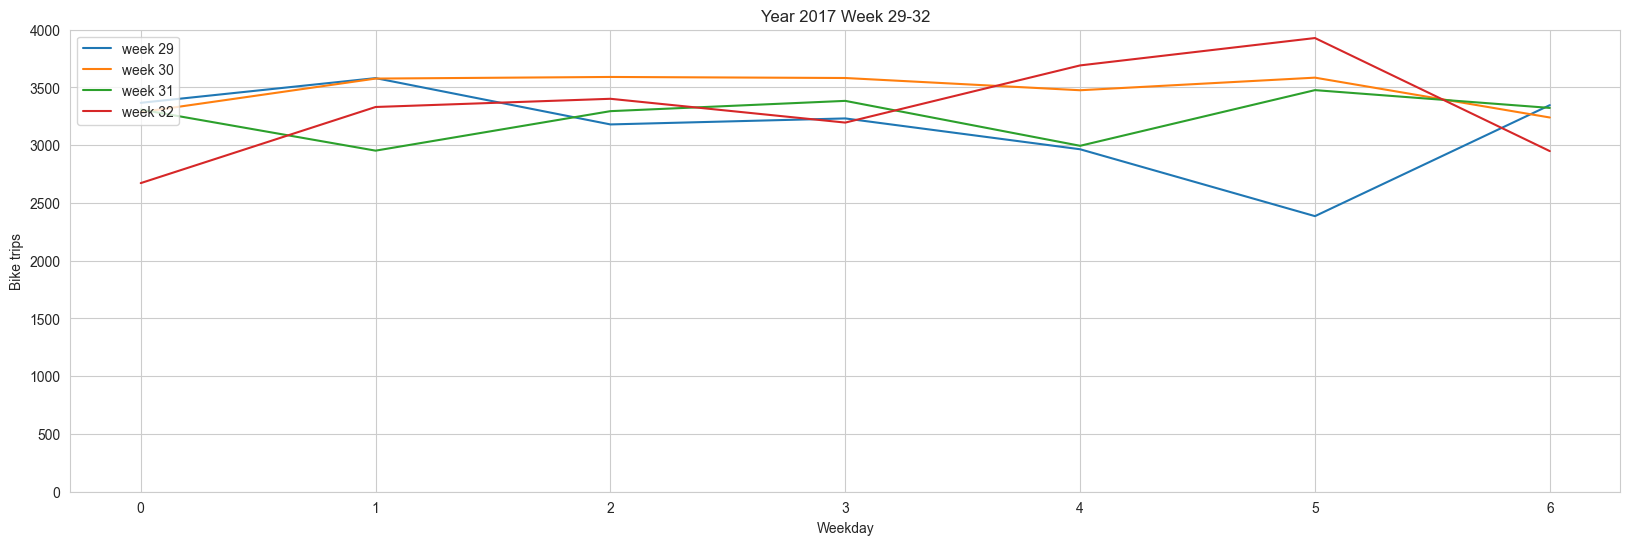

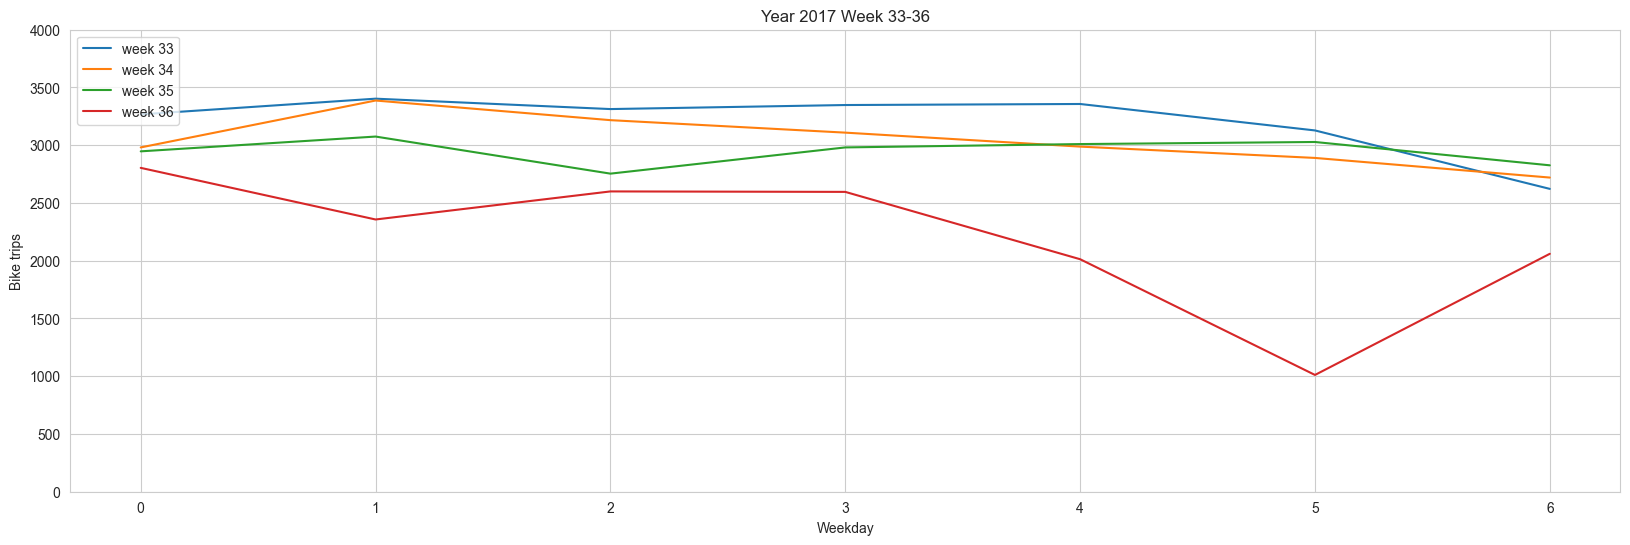

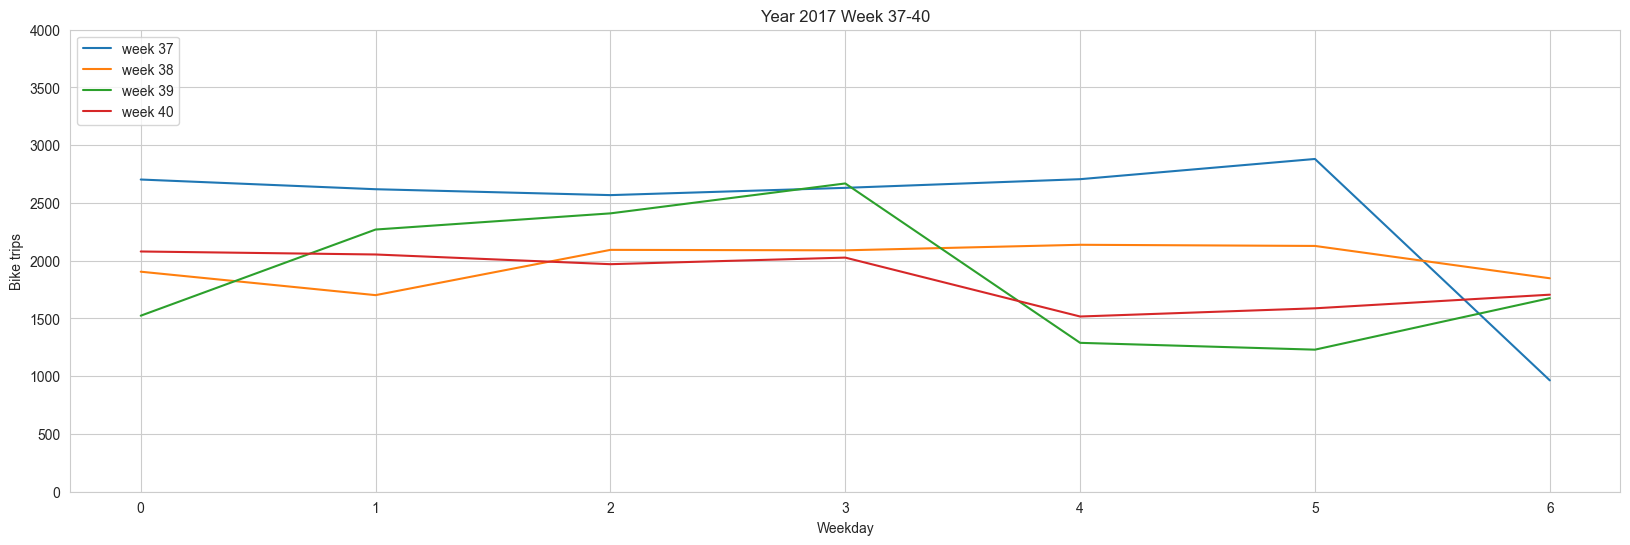

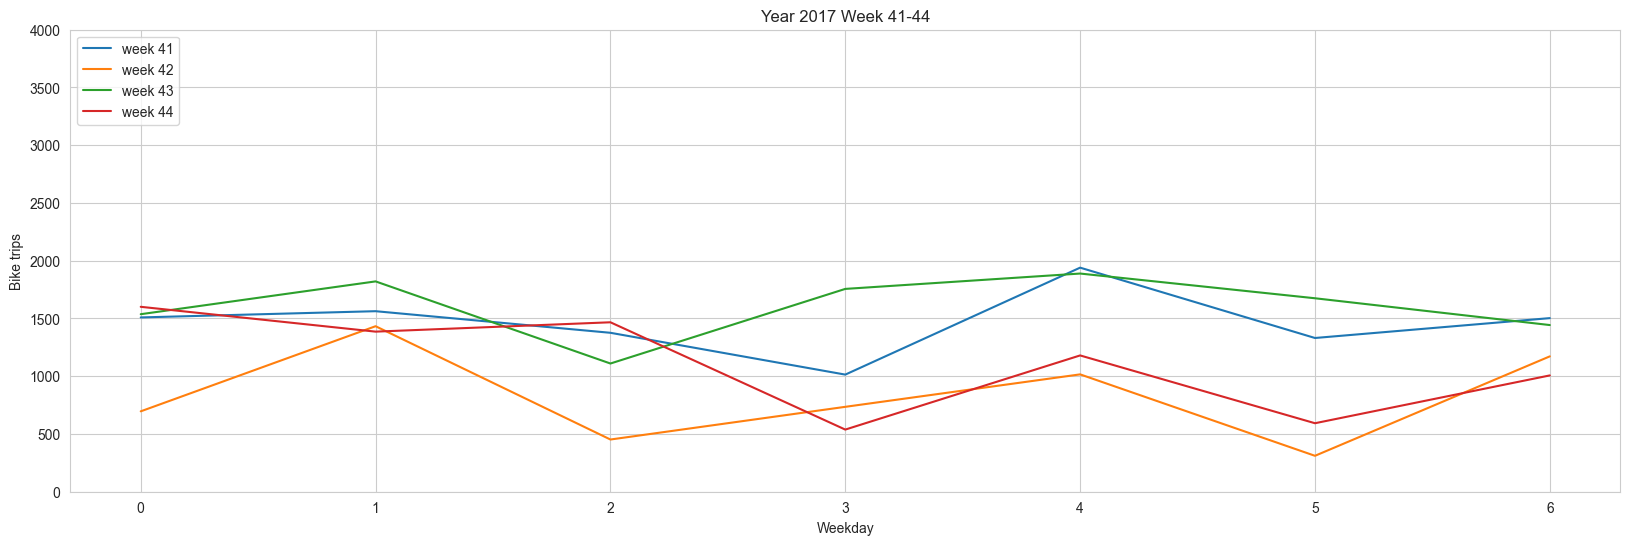

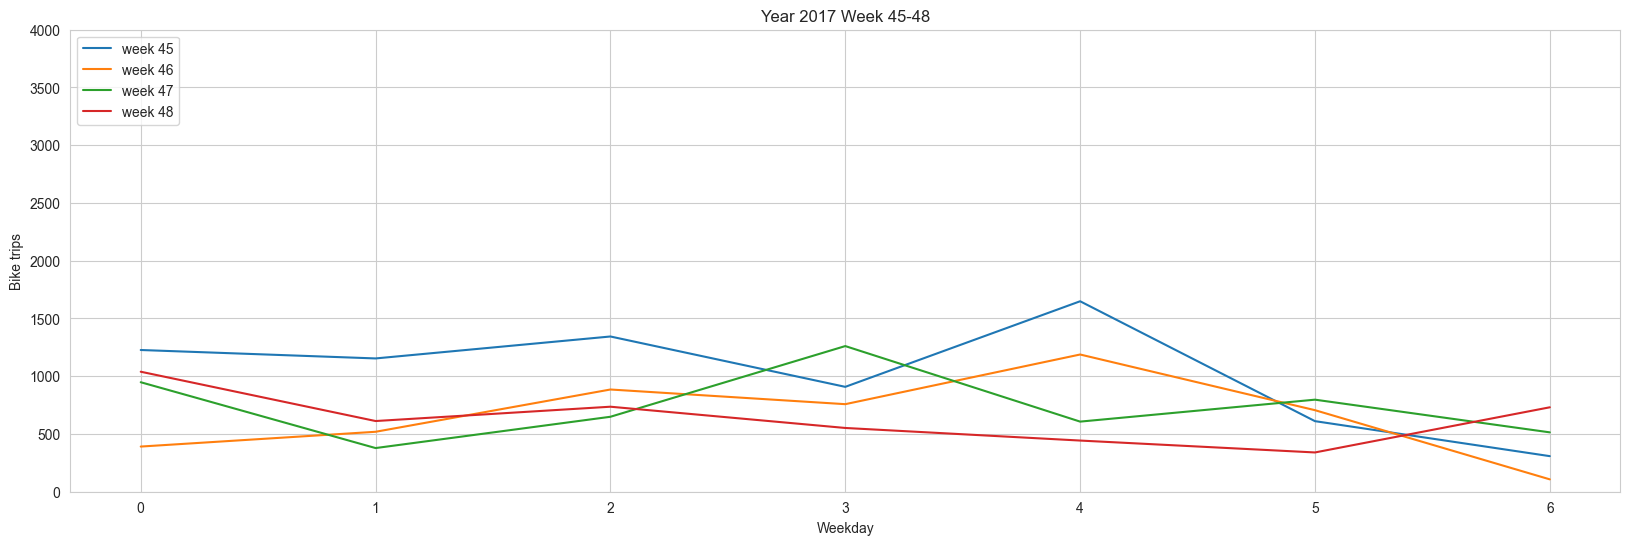

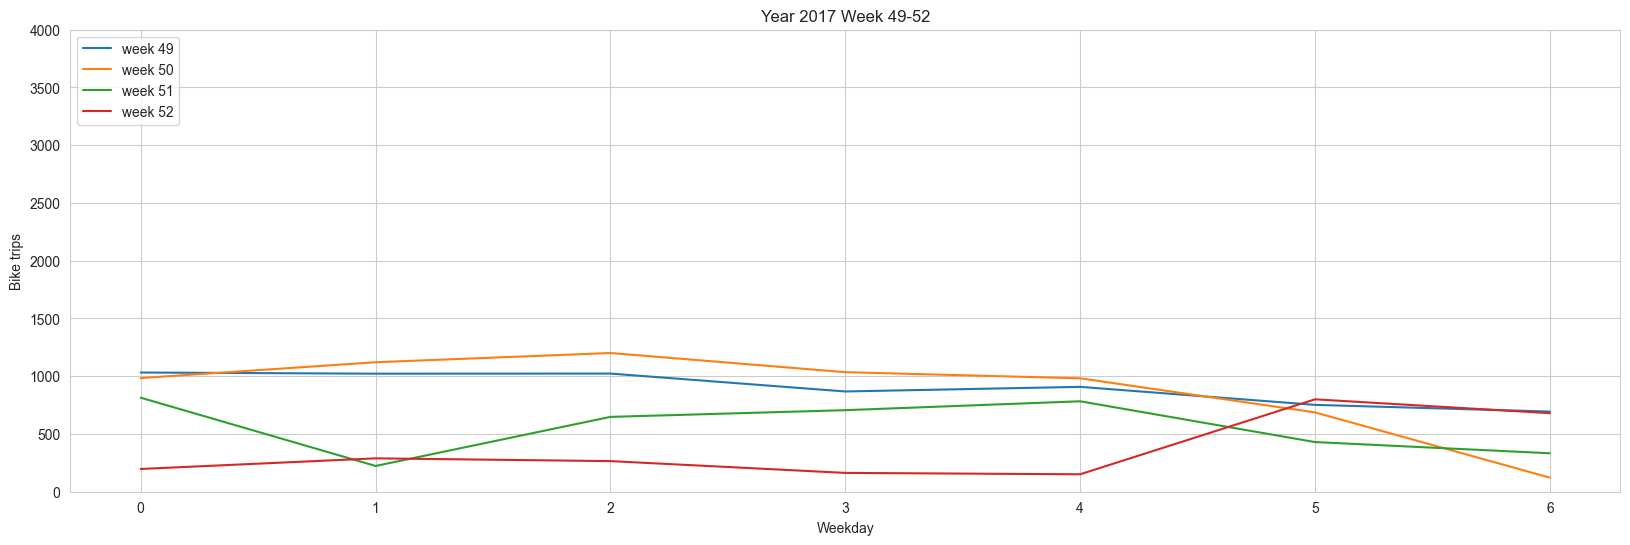

In [34]:
#Try plotting group_size weeks in group
group_size = 4
group_max = int(y_bike.Week.max()//group_size + 1)
    
for group_no in range(0,group_max-1):
    plt.figure(figsize=(20,6))
    for week in range(group_size * group_no + 1, group_size * group_no + group_size + 1):
        w_bike = y_bike.loc[y_bike.Week == week]
        sns.lineplot(data=w_bike,x='Weekday',y='Bike trips',label='week ' + str(week))
    plt.legend(loc=2)
    plt.title('Year 2017 Week ' + str(group_size * group_no + 1) + '-' + str(group_size * group_no + group_size))
    plt.ylim(0,4000)
    plt.show()
    
    


The plots don't show a clear sign of seasonality in weekdays. I suspect the weather data is much more relevant at daily scale than date. We should continue exploring the influence of weather data in another notebook.